In [ ]:
# create requirements.txt

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import random
from urllib import request
import shutil
import gzip
import os

# Prepare the Dataset

### Download and unzip the MNIST dataset

In [14]:
base_url = 'http://yann.lecun.com/exdb/mnist/'

dataset = ['train-images.idx3-ubyte', 'train-labels.idx1-ubyte',
           't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte']

for file in dataset:
    
    _file = file.replace('.', '-') + '.gz'
    
    if _file not in os.listdir():
        with request.urlopen(f'{base_url}{_file}') as response, open(_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        
    with gzip.open(_file, 'rb') as f_in, open(file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

### Load the dataset

In [78]:
train_images = idx2numpy.convert_from_file(dataset[0]) / 255.0
train_labels = idx2numpy.convert_from_file(dataset[1])
test_images = idx2numpy.convert_from_file(dataset[2]) / 255.0
test_labels = idx2numpy.convert_from_file(dataset[3])

### Plot a random sample

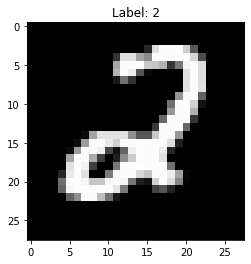

In [79]:
idx = random.randint(0, len(train_images))
plt.title(f'Label: {train_labels[idx]}')
plt.imshow(train_images[idx], cmap='gray')